In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Названия всех 43 колонок
column_names = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
    'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root',
    'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login',
    'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate',
    'diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
    'dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
    'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','label','difficulty'
]

# Загружаем обучающую выборку
train = pd.read_csv("KDDTrain+.txt", names=column_names)

# Удаляем колонку сложности
train = train.drop(columns=['difficulty'])

# Переводим метки: normal → 0, остальные → 1
train['label'] = train['label'].apply(lambda x: 0 if x == 'normal' else 1)

# Кодируем категориальные признаки
cat_cols = ['protocol_type', 'service', 'flag']
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    label_encoders[col] = le

# Делим данные
X_train = train.drop(columns=['label'])
y_train = train['label']

# Масштабируем
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

print("✅ Обучающая выборка обработана:", X_train_scaled.shape)

✅ Обучающая выборка обработана: (125973, 41)


In [5]:
# Загружаем тестовую выборку
test = pd.read_csv("KDDTest+.txt", names=column_names)

# Удаляем колонку сложности
test = test.drop(columns=['difficulty'])

# Переводим метки: normal → 0, остальные → 1
test['label'] = test['label'].apply(lambda x: 0 if x == 'normal' else 1)

# Кодируем категориальные признаки так же, как в train
for col in cat_cols:
    le = label_encoders[col]
    test[col] = le.transform(test[col])

# Делим на признаки и метки
X_test = test.drop(columns=['label'])
y_test = test['label']

# Масштабируем с тем же scaler, что и для train
X_test_scaled = scaler.transform(X_test)

print("✅ Тестовая выборка обработана:", X_test_scaled.shape)

✅ Тестовая выборка обработана: (22544, 41)


In [6]:
#Обучение модели Isolation Forest и оцениваем её работу по метрикам, потом оценим по KDDTest
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

model_IsFor = IsolationForest(
    n_estimators = 100,
    max_samples = X_train_scaled.shape[0],
    contamination = 0.47,
    random_state = 42
)
model_IsFor.fit(X_train_scaled) #процесс построения деревьев. после fir модель запомнила что есть "норма" и что етсь "аномалия" и готова к предсказанию

y_pred_test = model_IsFor.predict(X_test_scaled) #[1, -1, 1 ...]

y_pred_test_converted = np.where(y_pred_test == 1, 0, 1)

print ("===Confusion Matrix===")
print(confusion_matrix(y_test, y_pred_test_converted))

print("===Classification report===")
print(classification_report(y_test, y_pred_test_converted))

===Confusion Matrix===
[[ 6836  2875]
 [ 1896 10937]]
===Classification report===
              precision    recall  f1-score   support

           0       0.78      0.70      0.74      9711
           1       0.79      0.85      0.82     12833

    accuracy                           0.79     22544
   macro avg       0.79      0.78      0.78     22544
weighted avg       0.79      0.79      0.79     22544



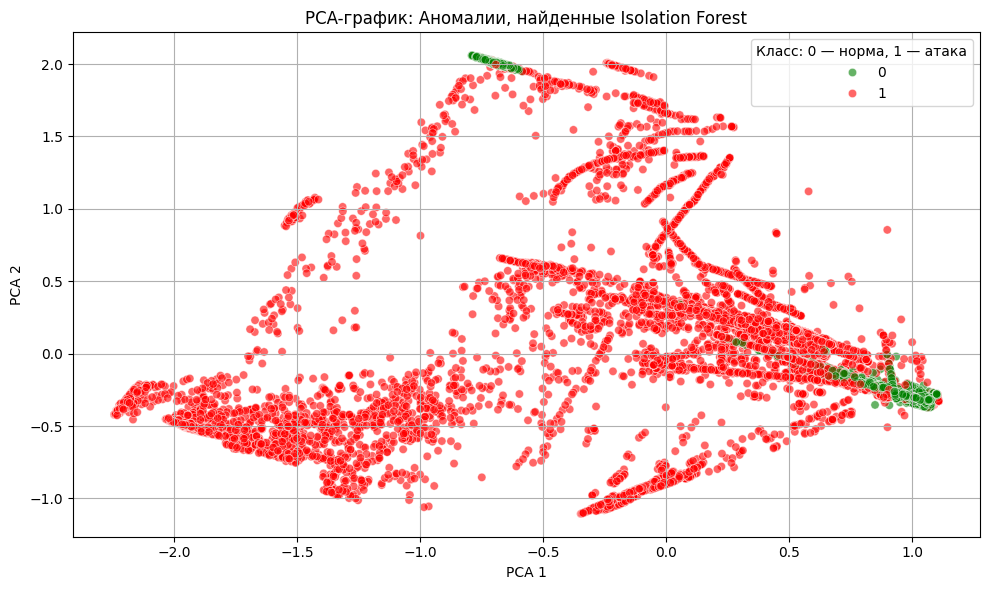

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Применяем PCA для снижения размерности
pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_test_scaled)

# Визуализация
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_test_2d[:, 0],
    y=X_test_2d[:, 1],
    hue=y_pred_test_converted,
    palette=["green", "red"],
    alpha=0.6
)

plt.title("PCA-график: Аномалии, найденные Isolation Forest")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Класс: 0 — норма, 1 — атака")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
from sklearn.neighbors import LocalOutlierFactor

# 1. Инициализация модели
model_lof = LocalOutlierFactor(
    n_neighbors=50,
    contamination=0.47,
    novelty=True  # проводим тест на KDDTest 
)

# Обучение на тренировочных данных
model_lof.fit(X_train_scaled)

# Предсказание на тестовых данных
y_pred_test_lof = model_lof.predict(X_test_scaled)

# Приведение к формату 0 / 1
y_pred_test_lof_converted = np.where(y_pred_test_lof == 1, 0, 1)

# Метрики
from sklearn.metrics import classification_report, confusion_matrix

print("=== Confusion Matrix (LOF) ===")
print(confusion_matrix(y_test, y_pred_test_lof_converted))

print("\n=== Classification Report (LOF) ===")
print(classification_report(y_test, y_pred_test_lof_converted))

=== Confusion Matrix (LOF) ===
[[4406 5305]
 [3697 9136]]

=== Classification Report (LOF) ===
              precision    recall  f1-score   support

           0       0.54      0.45      0.49      9711
           1       0.63      0.71      0.67     12833

    accuracy                           0.60     22544
   macro avg       0.59      0.58      0.58     22544
weighted avg       0.59      0.60      0.59     22544



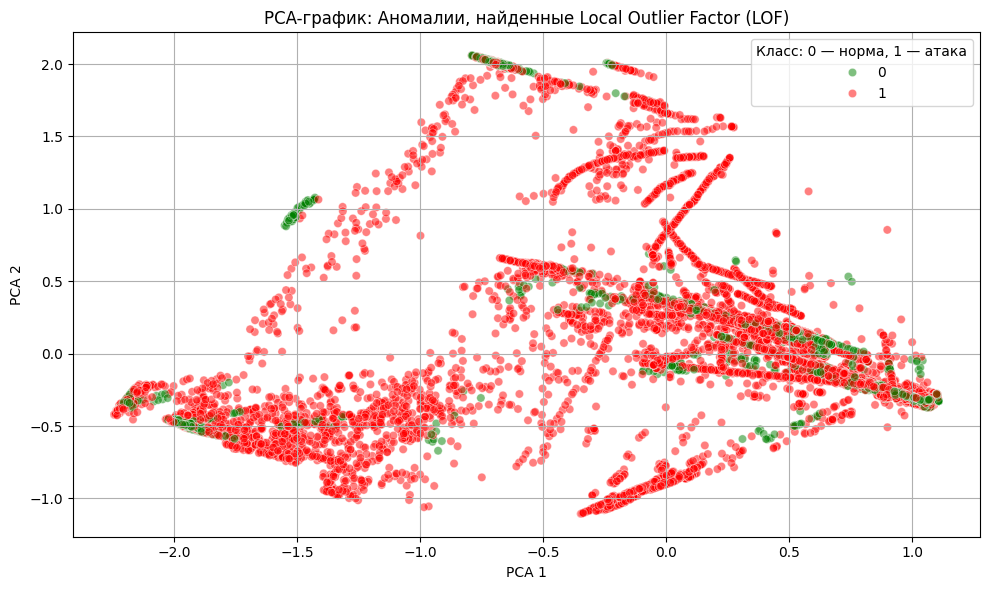

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Преобразуем данные в 2D с помощью PCA
pca_lof = PCA(n_components=2)
X_test_2d_lof = pca_lof.fit_transform(X_test_scaled)

# Построим график
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_test_2d_lof[:, 0],
    y=X_test_2d_lof[:, 1],
    hue=y_pred_test_lof_converted,
    palette=["green", "red"],
    alpha=0.5,
    legend="full"
)

plt.title("PCA-график: Аномалии, найденные Local Outlier Factor (LOF)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Класс: 0 — норма, 1 — атака")
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
import numpy as np
from tensorflow.keras.models import Model #для создания нейросети  
from tensorflow.keras.layers import Input, Dense #для создания нейросети
from tensorflow.keras.optimizers import Adam #Оптимизатор обучения 

input_dim = X_train_scaled.shape[1]#определяем кол-во признаков, это необходимо для нейросети например (22500[0], 41[1])

# 1. Слой входа
input_layer = Input(shape=(input_dim,))

# 2. Кодировщик. происходит сжатие данных, выделяя главное
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(16, activation='relu')(encoded)
encoded = Dense(8, activation='relu')(encoded)

# 3. Декодировщик. Восстанавливаю вход из сжатого представления 
decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded) 

# 4. Автоэнкодер
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# 5. Компиляция и обучение
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=20,
    batch_size=256,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)


Epoch 1/20
443/443 [==============================] - 3s 3ms/step - loss: 0.0475 - val_loss: 0.0114
Epoch 2/20
443/443 [==============================] - 1s 3ms/step - loss: 0.0078 - val_loss: 0.0060
Epoch 3/20
443/443 [==============================] - 1s 3ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 4/20
443/443 [==============================] - 1s 3ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 5/20
443/443 [==============================] - 1s 3ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 6/20
443/443 [==============================] - 1s 3ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 7/20
443/443 [==============================] - 1s 3ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 8/20
443/443 [==============================] - 1s 3ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 9/20
443/443 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 10/20
443/443 [==============================] - 1s 3ms/step - loss: 0.0038 - val_loss: 0.0038

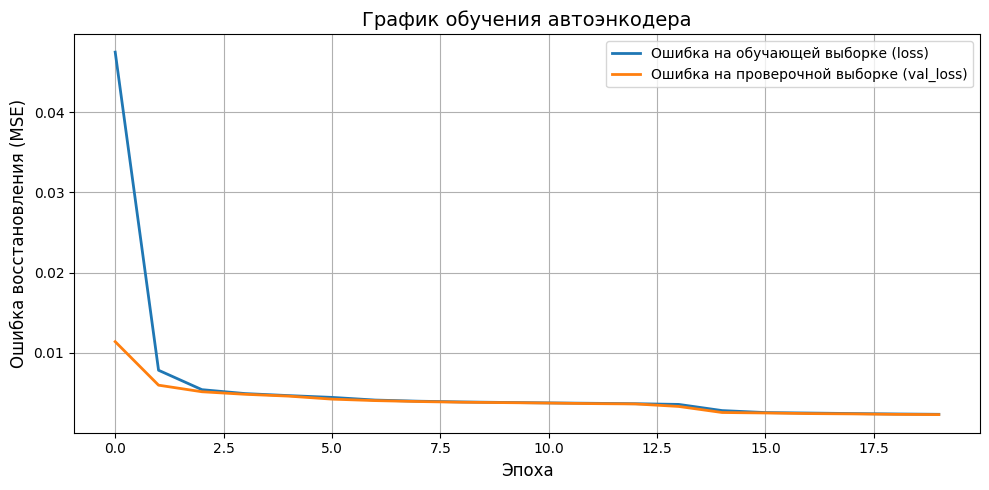

In [11]:
import matplotlib.pyplot as plt

# Построение графика ошибок
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Ошибка на обучающей выборке (loss)', linewidth=2)
plt.plot(history.history['val_loss'], label='Ошибка на проверочной выборке (val_loss)', linewidth=2)

plt.title('График обучения автоэнкодера', fontsize=14)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Ошибка восстановления (MSE)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# Прогоняем тестовые данные через автоэнкодер
X_test_pred = autoencoder.predict(X_test_scaled)

# Вычисляем ошибку восстановления (среднеквадратичную ошибку)
reconstruction_errors = np.mean(np.square(X_test_scaled - X_test_pred), axis=1)

# Устанавливаем порог: 95-й процентиль ошибки — всё, что выше, считаем аномалией
threshold = np.percentile(reconstruction_errors, 95)

# Предсказанные метки: 1 — атака, 0 — норма
y_pred_ae = np.where(reconstruction_errors > threshold, 1, 0)

705/705 [==============================] - 2s 1ms/step


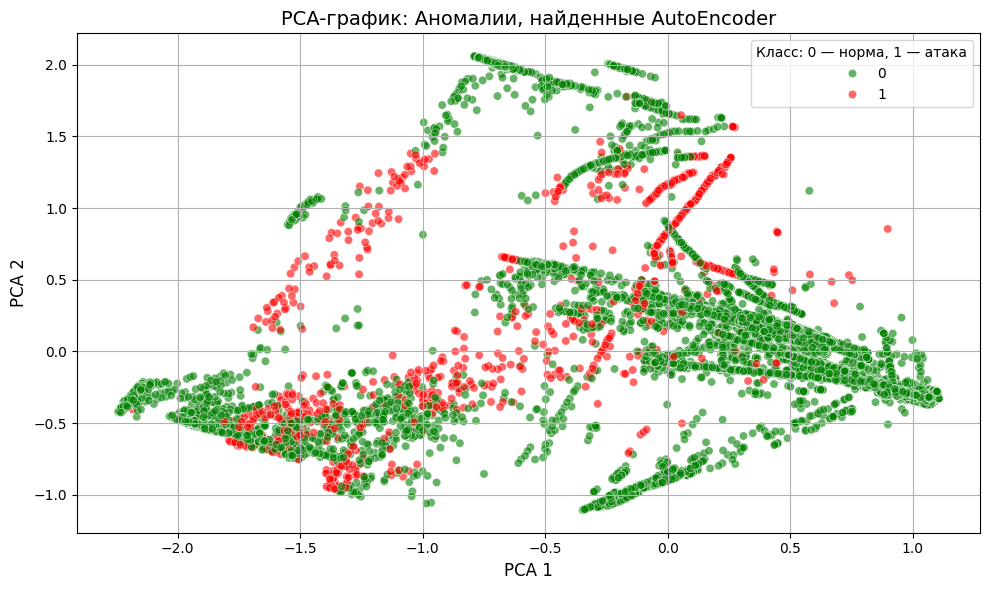

In [14]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Уменьшим размерность до 2D для визуализации
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_test_scaled)

# Строим график
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1],
                hue=y_pred_ae, palette={0: "green", 1: "red"}, alpha=0.6)

plt.title("PCA-график: Аномалии, найденные AutoEncoder", fontsize=14)
plt.xlabel("PCA 1", fontsize=12)
plt.ylabel("PCA 2", fontsize=12)
plt.legend(title="Класс: 0 — норма, 1 — атака")
plt.grid(True)
plt.tight_layout()
plt.show()